# Group Mahalanobis Project 1


## Introduction/Brief Description

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nam pulvinar sagittis erat, eget commodo lectus luctus in. Sed a erat eget felis convallis ultricies. Morbi pharetra quam at volutpat pharetra. Donec bibendum ex sed dignissim imperdiet. Proin fringilla purus tellus, vel posuere eros sagittis vitae. Cras commodo suscipit dui, quis commodo ex pharetra sed. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Ut elit massa, dignissim et dui at, molestie hendrerit dui. Nunc non blandit tellus.


## Project Deliverables

### [#A] Data Imports

In [1]:
"""
If necessary, uncomment and install:
"""
#!pip install wbdata
#!pip install cufflinks
#!pip install iso3166

import iso3166 #iso3166.countries.get('country details')
import wbdata
import cufflinks as cf
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
cf.go_offline()

We are using data from **Source 40: "Population Estimates and Projections"**. We can also use **wbdata.get_topic()** and **wbdata.get_indicator()** to explore other datasets.

WBDATA API ref: https://wbdata.readthedocs.io/en/stable/wbdata_library.html

In [2]:
#wbdata.get_source() to get all sources
#wbdata.get_topic()
#wbdata.get_indicator()

source_id = 40 #Population Estimates and Projections
indicators = wbdata.get_indicator(source=source_id)

### [#A] Population DataFrames

A function that returns a pandas DataFrame
indexed by Region or Country and Year, with
columns giving counts of people in different
age-sex groups:

**pop_df (year, group, age_lower, age_upper, location)**

In [4]:
"""
population ranges available from dataset:
00-04, 05-09, 10-14, 15-19, 20-24, 25-29, 30-34, ..., 70-74, 75-79, above 80
"""

def pop_df(year='2021', group='all', age_lower=0, age_upper=100, location='world'):
    df = pop_df_helper(year, age_lower, age_upper, location)
        
    if group == 'males':
        return df.drop(columns = ['Female'])
    elif group == 'females':
        return df.drop(columns = ['Male'])
    else:
        total_pop = df["Female"] + df["Male"]
        df["Total"] = total_pop
    return df

# Returns a list of input strings for population age ranges
def pop_df_helper(year, age_lower, age_upper, location):
    if location != 'world':
        country_alpha3 = iso3166.countries.get(location).alpha3
        country_name = iso3166.countries.get(location).apolitical_name
    else:
        country_alpha3 = 'WLD'
        country_name = 'World'
    inputs = list_of_age_inputs(age_lower, age_upper)

    #create indicator-dictionaries required for WBData API
    indicator_dict_m = {}
    indicator_dict_f = {}
    for i in inputs:
        key_m = "SP.POP.{}.{}".format(i, 'MA')
        key_f = "SP.POP.{}.{}".format(i, 'FE')
        value = "{}-{}".format(i[:2], i[2:])
        indicator_dict_m[key_m] = value
        indicator_dict_f[key_f] = value

    #source_id = 40, refer to wbdata.get_source()
    wbdf_m = wbdata.get_dataframe(indicator_dict_m, country=country_alpha3, source=source_id)
    wbdf_f = wbdata.get_dataframe(indicator_dict_f, country=country_alpha3, source=source_id)
    datas_m = wbdf_m.query("date=='{}'".format(year)).sum(axis=0).tolist()
    datas_f = wbdf_f.query("date=='{}'".format(year)).sum(axis=0).tolist()
    df = pd.DataFrame({
        'Country': country_name,
        'Year': year,
        'Age': list(indicator_dict_m.values()),
        'Female': datas_f,
        'Male': datas_m
    })
    return df

# Returns a list of input strings for population age ranges
def list_of_age_inputs(age_lower, age_upper):
    def round_down(n):
        return max(0, n - n % 5)

    def round_up(n):
        return n - n % 5 + 5

    results = []
    r_lower_bound, r_upper_bound = round_down(age_lower), round_up(age_upper)   
    while r_lower_bound < min(79, r_upper_bound):
        results.append("{:02d}{:02d}".format(r_lower_bound, r_lower_bound + 4))
        r_lower_bound += 5
    if age_upper >= 80:
        results.append('80UP')
    return results

The **pop_df** function takes in the year, target group, age lower/upper bounds and the country as arguments. The function returns a dataframe.

Variables:

In [5]:
year = 2015 #1960 to 2050 (projections)
group = 'all' #males/females/all
age_lower = 13 #rounds to nearest 5 (actual range: 10 to 65)
age_upper = 61
location = 'myanmar' #accepts country names/abbreviations, 'world'

Function call and output:

In [6]:
df = pop_df(year, group, age_lower, age_upper, location)

A dataframe is returned with the above format. The returned dataframe can be used to construct visualizations.

### [#A] Population Statistics

A python function named population
that will deliver information to
answer the queries of the following
form:

In [year] how many
[people/males/females] aged [low] to
[high] were living in [the
world/region/country]?

**pop_stats (year, group, age_lower, age_upper, location)**

In [7]:
def pop_stats(year='2021', group='all', age_lower=0, age_upper=100, location='world'):
    df = pop_df(year, group, age_lower, age_upper, location)
    inputs = list_of_age_inputs(age_lower, age_upper);
    total = df.sum()[3]
    t = total.astype(int)
    age_l = inputs[0][0:2]
    
    if group == 'people':
        g = 'people'
    else:
        g = group
        
    if age_upper >= 80:
        age_h = '80 or over'
    else:
        age_h = inputs[-1][2:4]
    
    if location == 'world':
        loc = 'the world'
    else:
        loc = iso3166.countries.get(location).apolitical_name
    
    if year > 2021:
        print("By estimation, in {}, there will be {} {} aged {} to aged {} living in {}.".format(year, t, g, age_l, age_h, loc))
    else:
        print("In {}, there are {} {} aged {} to aged {} living in {}.".format(year, t, g, age_l, age_h, loc))
        

Our **pop_stats** function takes in the year, target group, age lower/upper bounds and the country as arguments. The function returns a summary containing the information we need.

Variables:

In [8]:
year = 2021
group = 'males'
age_lower = 10
age_upper = 45
location = 'world'

Function call and output:

In [170]:
#pop_stats(year, group, age_lower, age_upper, location)

### [#B] Population Pyramids

A python function that takes as
input a pandas DataFrame with
columns providing counts of people by
age-sex groups, and constructs a
“population pyramid” graph for
visualizing the data.

**draw_pop_pyramid (dataframe)**

In [9]:
def draw_pop_pyramid(df):
    #negate values under 'Male'
    df['Male'] = df['Male'].apply(lambda x: -x)
    #remove unnecessary columns
    df.drop(columns = ['Country', 'Year', 'Total'])

    AgeClass = df['Age'][::-1]
    bar_plot = sns.barplot(x='Female', y='Age', data=df, order=AgeClass)
    bar_plot = sns.barplot(x='Male', y='Age', data=df, order=AgeClass)
    bar_plot.set(xlabel="Population (millions)", ylabel="Age-Group", title = "Population Pyramid")

**draw_pop_pyramid** function call and output:

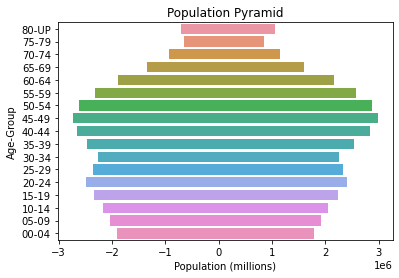

In [10]:
year = 2018
group = 'all'
age_lower = 0
age_upper = 80
location = 'thailand'

df = pop_df(year, group, age_lower, age_upper, location)
draw_pop_pyramid(df) 

#### Functions we have so far:
**pop_df(year, group, age_lr, age_up, location)**: returns a dataframe for visualizations<br>
**pop_stats(year, group, age_lr, age_up, location)**: returns a print statement containing population information<br>
**draw_pop_pyramid(dataframe)**: accepts a dataframe created using pop_df(), and creates a population histogram

### [#C] Animated Population Pyramids

A python function that takes as
input a pandas DataFrame with
columns providing counts of people by
age-sex groups, with rows
corresponding to different years, and
constructs an animated “population
pyramid” graph for visualizing how the
population changes over time.

In [11]:
import plotly.offline as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np

In [169]:
# which take the form "SP.POP.LLHH.MA" for males
# and "SP.POP.LLHH.FE" for females, where LL is the *low* end of
# age range, like "05" for 5-yo, and HH is the *high* end.
# We construct a list of age-ranges.
# Start with an empty list of age-rages
age_ranges = []

# Ranges top out at 80, and go in five year increments
for i in range(0,80,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

age_ranges.append("80UP")

print(age_ranges)

['0004', '0509', '1014', '1519', '2024', '2529', '3034', '3539', '4044', '4549', '5054', '5559', '6064', '6569', '7074', '7579', '80UP']


In [85]:
male_variables = {"SP.POP."+age_range+".MA":"Males "+age_range for age_range in age_ranges}
female_variables = {"SP.POP."+age_range+".FE":"Females "+age_range for age_range in age_ranges}
variables = male_variables
variables.update(female_variables)

In [86]:
df = wbdata.get_dataframe(variables,country="THA")

In [99]:
df.head()

,Males 0004,Males 0509,Males 1014,Males 1519,Males 2024,Males 2529,Males 3034,Males 3539,Males 4044,Males 4549,...,Females 3539,Females 4044,Females 4549,Females 5054,Females 5559,Females 6064,Females 6569,Females 7074,Females 7579,Females 80UP
date,,,,,,,,,,,,,,,,,,,,,
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,1876615.0,2006539.0,2142827.0,2287403.0,2470482.0,2393282.0,2233931.0,2413272.0,2624654.0,2704966.0,...,2464552.0,2787726.0,2953019.0,2917027.0,2627389.0,2245432.0,1673313.0,1207424.0,870524.0,1116998.0
2018,1898694.0,2037800.0,2165579.0,2337243.0,2480114.0,2347954.0,2256588.0,2469020.0,2663061.0,2727865.0,...,2534929.0,2838892.0,2975493.0,2879749.0,2580579.0,2150789.0,1589109.0,1152333.0,847589.0,1063386.0
2017,1919767.0,2067966.0,2188991.0,2388765.0,2477988.0,2300292.0,2295473.0,2526480.0,2696518.0,2746535.0,...,2608520.0,2882586.0,2990228.0,2832558.0,2532234.0,2049309.0,1511289.0,1104473.0,830388.0,1006894.0
2016,1945308.0,2095464.0,2217456.0,2432836.0,2463668.0,2263674.0,2342460.0,2582194.0,2727119.0,2756923.0,...,2679918.0,2920598.0,2993495.0,2782083.0,2475000.0,1948423.0,1439357.0,1064111.0,814731.0,948801.0


In [172]:
import plotly.graph_objs as go
import ipywidgets
from ipywidgets import interactive, HBox, VBox

def helper(year):
    py.init_notebook_mode(connected=True)
    layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'))
    bins = [go.Bar(x = df.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='green'),
               hoverinfo='skip'
               ),
        go.Bar(x = -df.loc[str(year),:].filter(regex="Female").values,
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='pink'),
               hoverinfo='skip',
               )
        ]
    py.iplot(dict(data=bins, layout=layout))
ipywidgets.interact(helper, year=(1980, 2018, 1))

interactive(children=(IntSlider(value=1999, description='year', max=2018, min=1980), Output()), _dom_classes=(…

<function __main__.helper(year)>

### [#C] Population Maps

A Jupyter notebook which queries a
population database and provides
visualizations in the form of maps.
An example of a library that may be
useful is geopandas.

In [52]:
#!pip install geopandas
import geopandas

In [53]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

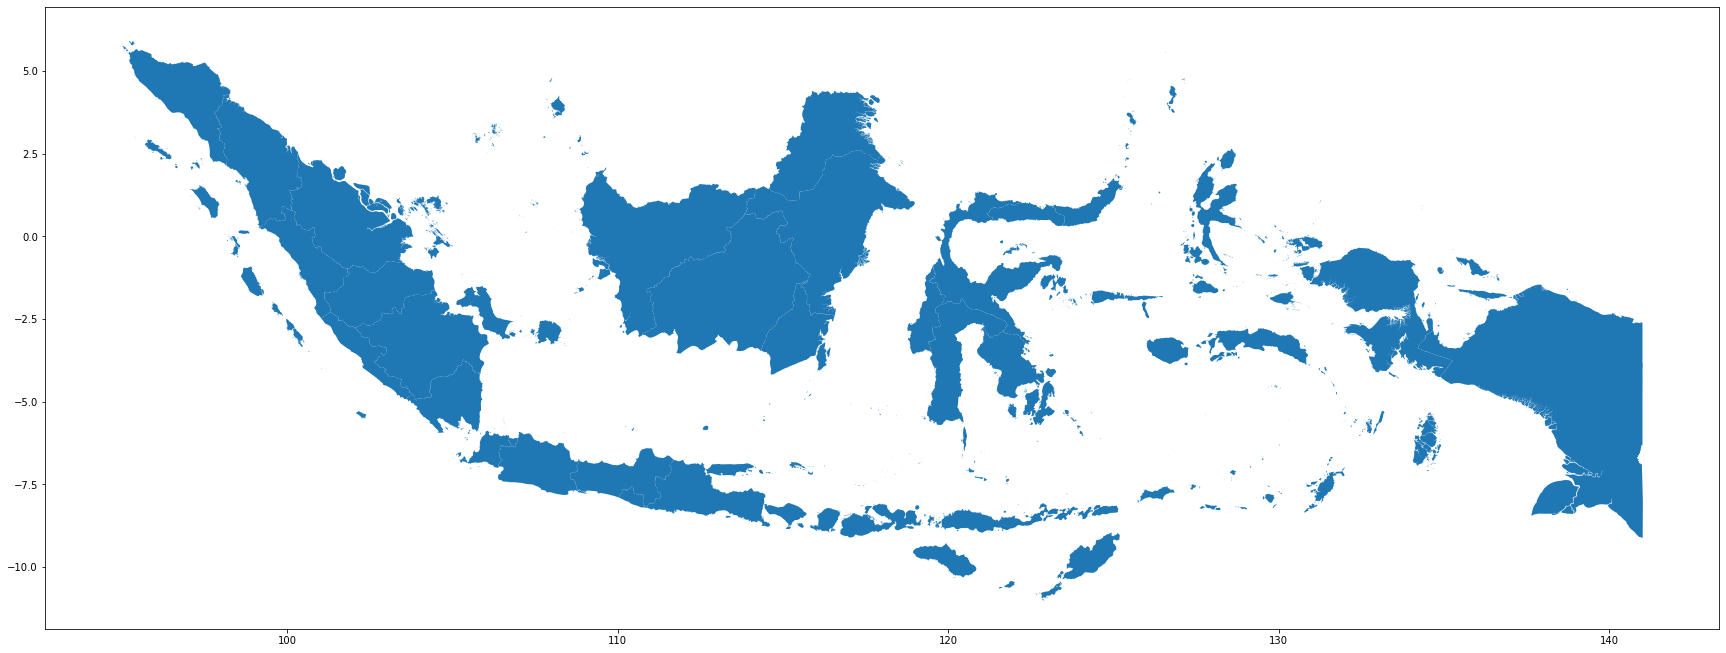

In [66]:
fp = "IDN_adm/IDN_adm1.shp"
map_df = gpd.read_file(fp)
plt.rcParams['figure.figsize'] = [30, 50] 
map_df.plot()

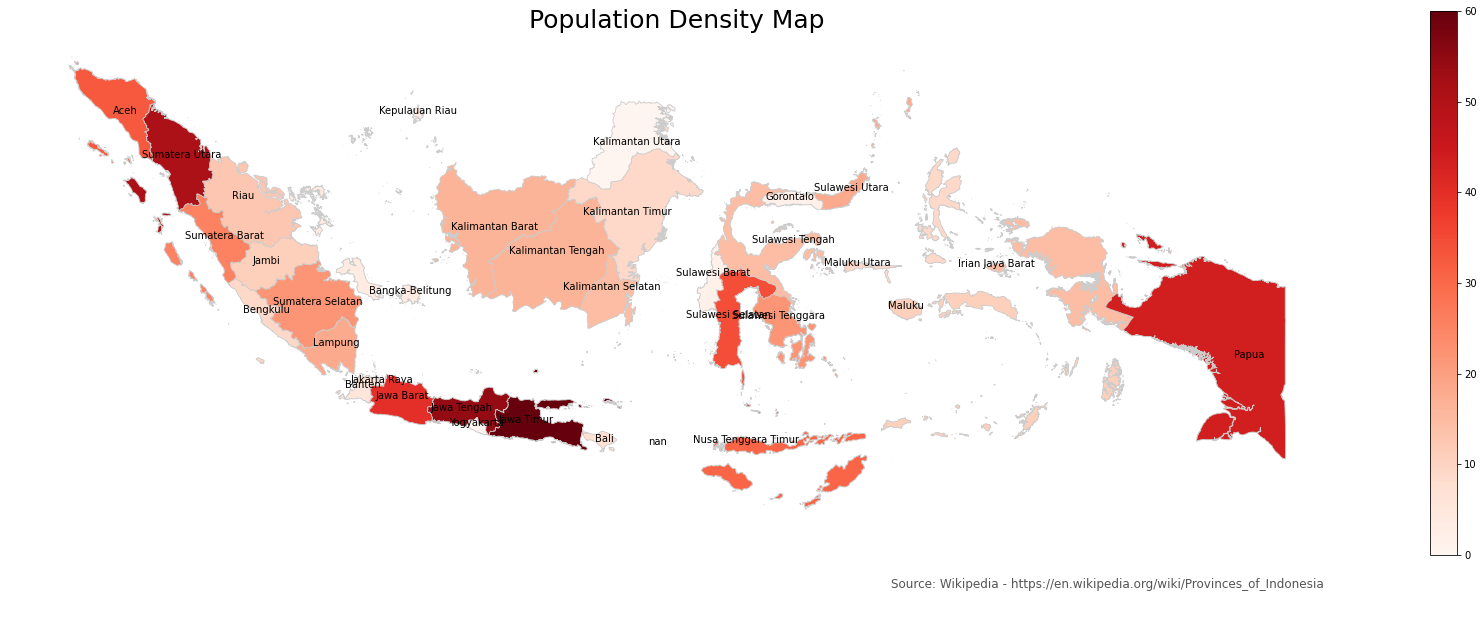

In [133]:
province = pd.read_csv("data_province.csv", sep=";")
merged = map_df.merge(province, how='left', left_on="NAME_1", right_on="province")
merged = merged[['province', 'geometry', 'population_2015', 'area_km2', 'population_density_per_km2',
                'cities_regencies', 'cities', 'regencies']]
variable = 'cities_regencies'
vmin, vmax = 0, 60
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('Population Density Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia',xy=(0.6, .05),
            xycoords='figure fraction', fontsize=12, 
            color='#555555')
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) 
fig.colorbar(sm)
merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
for idx, row in merged.iterrows():
    plt.annotate(s=row['province'], xy=row['coords'],horizontalalignment='center')

### [#C] Other Visualization Tools

If you think of other ways to organize
or visualize population and how it
changes over time, this is for you!

In [26]:
countries = ['Myanmar', 'Thailand', 'Vietnam', 'Singapore', 'Indonesia', 'Cambodia', 'Brunei']

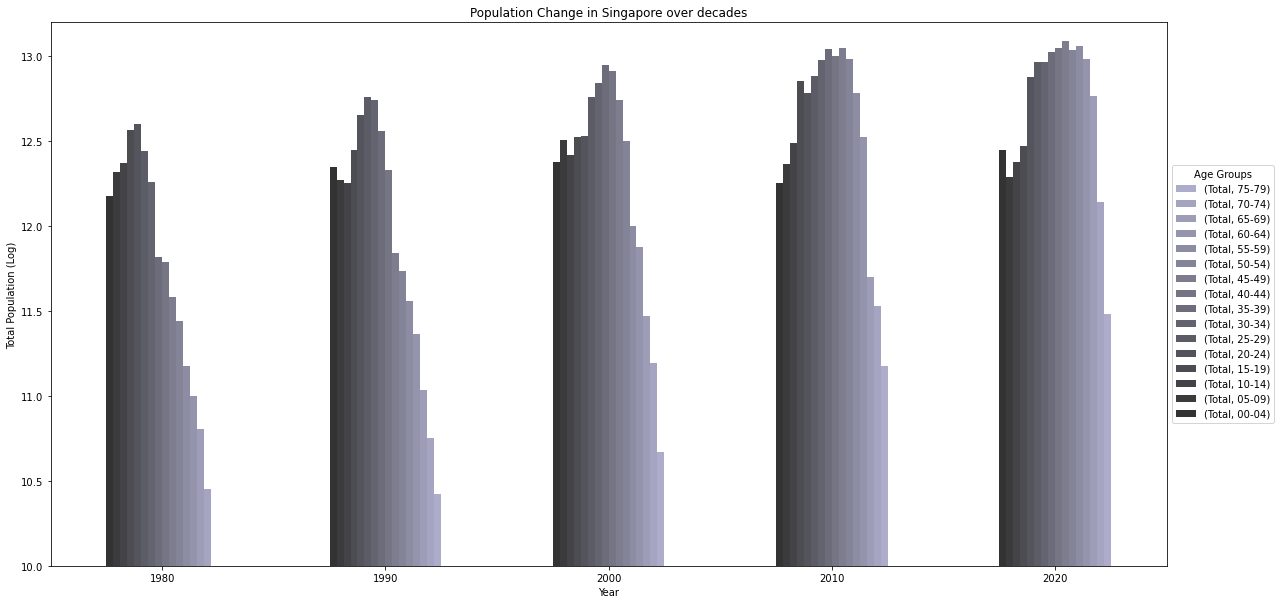

In [134]:
group = 'all' #males/females/all
age_lower = 0 #rounds to nearest 5 (actual range: 10 to 65)
age_upper = 79
location = 'Singapore' #accepts country names/abbreviations, 'world'

years = [1980, 1990, 2000, 2010, 2020]
frames = []
for y in years:
    frames.append(pop_df(y, group, age_lower, age_upper, location))
    
result = pd.concat(frames, axis=0, ignore_index = True)
result = result.drop(columns = ['Male', 'Female', 'Country'])
result = result.pivot(index='Year', columns='Age')

for c in result:
    result[c] = np.log(result[c])

my_colors = [(x/25, x/25, x/20, 0.75) for x in range(17)] 
graph = result.plot(kind='bar', figsize=(20,10), ylim=(10, 13.2), legend='reverse', rot=0, alpha=0.8, color=my_colors)
handles, labels = graph.get_legend_handles_labels()
graph.set_ylabel('Total Population (Log)');
graph.set_title("Population Change in {} over decades".format(location))
graph.legend(handles[::-1], labels[::-1], title='Age Groups', loc='center left', bbox_to_anchor=(1.0, 0.5));

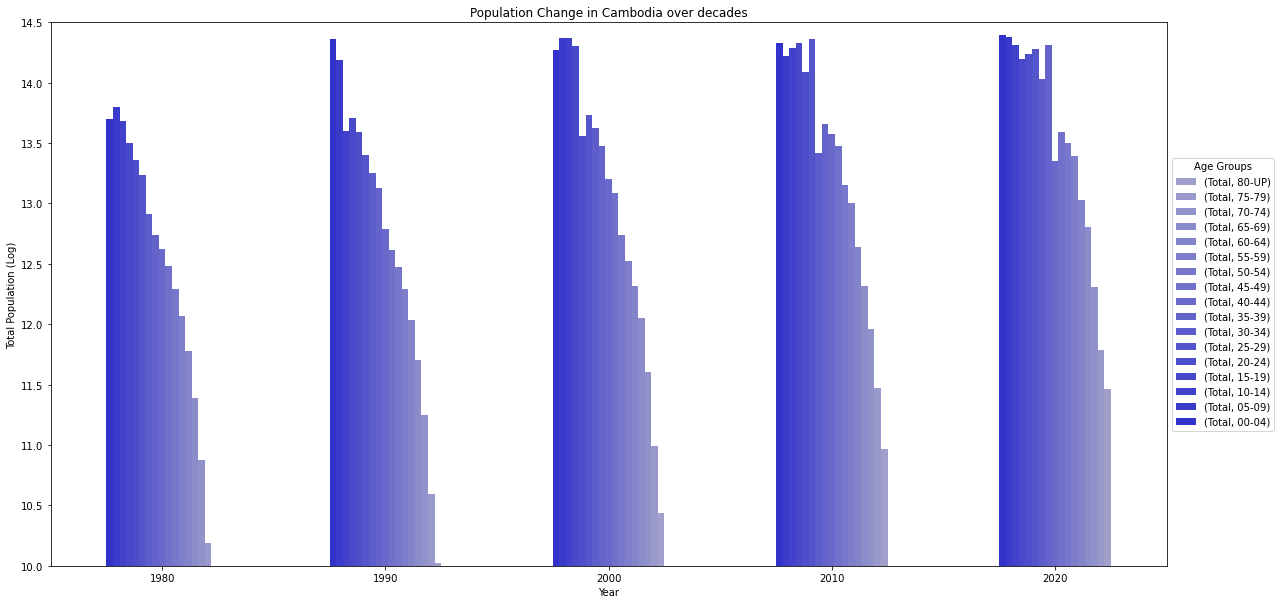

In [135]:
group = 'all' #males/females/all
age_lower = 0 #rounds to nearest 5 (actual range: 10 to 65)
age_upper = 85
location = 'Cambodia' #accepts country names/abbreviations, 'world'

years = [1980, 1990, 2000, 2010, 2020]
frames = []
for y in years:
    frames.append(pop_df(y, group, age_lower, age_upper, location))
    
result = pd.concat(frames, axis=0, ignore_index = True)
result = result.drop(columns = ['Male', 'Female', 'Country'])
result = result.pivot(index='Year', columns='Age')

for c in result:
    result[c] = np.log(result[c])

my_colors = [(x/30, x/30, 0.75) for x in range(17)] 
graph = result.plot(kind='bar', figsize=(20,10), ylim=(10, 14.5), legend='reverse', rot=0, alpha=0.8, color=my_colors)
handles, labels = graph.get_legend_handles_labels()
graph.set_ylabel('Total Population (Log)');
graph.set_title("Population Change in {} over decades".format(location))
graph.legend(handles[::-1], labels[::-1], title='Age Groups', loc='center left', bbox_to_anchor=(1.0, 0.5));

### [#C] Agricultural Supply

Relate changes in agricultural food supply
to changes in population.

What would Malthus think?

In [114]:
import numpy as np
from plotly.offline import init_notebook_mode, iplot
from scipy.optimize import newton

init_notebook_mode(connected=True)

# Play with these constants
## for exponential
P0 = 1
r = 0.02

## for line
F0 = 10
m = 100

food_production = lambda t,m=m: F0+m*t
population = lambda t,r=r: P0*np.exp(r*t)
diff = lambda t,r=r,m=m: food_production(t,m) - population(t,r)
# Point where curves cross
def choose_xaxis(r,m,x0=10):
    """
    Find a range of x so that curves intersect
    """
    tstar = -1
    try:
        while tstar <= 0:
            tstar = newton(lambda t: diff(t,r,m),x0,maxiter=1000)
            x0 = x0*10
        return np.linspace(0,tstar*1.1,100)
    except RuntimeError: # Failed to find root
        return np.linspace(0,1000,100)

In [30]:
import plotly.graph_objs as go
from ipywidgets import interactive, HBox, VBox

T = choose_xaxis(r,m)

data = [dict(name='Food production',
             #visible = False,
             line=dict(color='blue', width=6),
             x = T,
             y = [food_production(t) for t in T]),
        dict(name='Population',
             #visible = False,
             line=dict(color='red', width=6),
             x = T,
             y = [population(t) for t in T])]

layout = {}
#fig = dict(data=data, layout=layout)
#plot(fig)
f = go.FigureWidget(data=data,layout=layout)
def update_pop(r,m):
    T = choose_xaxis(r,m)
    f.data[1].y = [population(t,r) for t in T]
    f.data[0].x = T
    f.data[1].x = T
r_slider = interactive(update_pop,r=(-0.05,0.08,.01),m=(0,200,10))
vb = VBox((f, r_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'line': {'color': 'blue', 'width': 6},
              'name': 'Food…

In [31]:
import numpy as np
import wbdata
import cufflinks as cf
cf.go_offline()

def fix_date_index(df):
    idx_vars = df.index.names
    new = df.reset_index()
    new.date = new.date.astype(int)
    return new.set_index(idx_vars)

In [32]:
wbdata.get_topic()

  id  value
----  -------------------------------
   1  Agriculture & Rural Development
   2  Aid Effectiveness
   3  Economy & Growth
   4  Education
   5  Energy & Mining
   6  Environment
   7  Financial Sector
   8  Health
   9  Infrastructure
  10  Social Protection & Labor
  11  Poverty
  12  Private Sector
  13  Public Sector
  14  Science & Technology
  15  Social Development
  16  Urban Development
  17  Gender
  18  Millenium development goals
  19  Climate Change
  20  External Debt
  21  Trade

In [33]:
wbdata.get_indicator(topic=1)

id                    name
--------------------  ------------------------------------------------------------------------------------------
AG.AGR.TRAC.NO        Agricultural machinery, tractors
AG.CON.FERT.PT.ZS     Fertilizer consumption (% of fertilizer production)
AG.CON.FERT.ZS        Fertilizer consumption (kilograms per hectare of arable land)
AG.LND.AGRI.K2        Agricultural land (sq. km)
AG.LND.AGRI.ZS        Agricultural land (% of land area)
AG.LND.ARBL.HA        Arable land (hectares)
AG.LND.ARBL.HA.PC     Arable land (hectares per person)
AG.LND.ARBL.ZS        Arable land (% of land area)
AG.LND.CREL.HA        Land under cereal production (hectares)
AG.LND.CROP.ZS        Permanent cropland (% of land area)
AG.LND.EL5M.RU.K2     Rural land area where elevation is below 5 meters (sq. km)
AG.LND.EL5M.RU.ZS     Rural land area where elevation is below 5 meters (% of total land area)
AG.LND.FRST.K2        Forest area (sq. km)
AG.LND.FRST.ZS        Forest area (% of land area)

In [173]:
vars = {"AG.PRD.CREL.MT":"Cereal production"}
use=["CHN","USA","IND","FRA","RUS","WLD"]
cereals = fix_date_index(wbdata.get_dataframe(vars,country=use)).squeeze().unstack('country')
cereals.iplot(xTitle="Year",yTitle="Metric Tons",
              title="Cereal Production by Top 5 (in 2000)")

In [53]:
vars = {"AG.PRD.LVSK.XD":"Livestock index",
        "AG.PRD.FOOD.XD":"Food index",
        "AG.PRD.CROP.XD":"Crop index"}
food = fix_date_index(wbdata.get_dataframe(vars,country='WLD'))
food.iplot(xTitle="Year",yTitle="Index")

In [112]:
vars = {"AG.PRD.LVSK.XD":"Livestock index",
        "AG.PRD.FOOD.XD":"Food index",
        "AG.PRD.CROP.XD":"Crop index",
        "SP.POP.TOTL":"Population"}
food = fix_date_index(wbdata.get_dataframe(vars,country='WLD'))
food.sort_index(inplace=True)
food['Population'] = food['Population']/food.loc[2006,'Population']*100
food.iplot(xTitle="Year",yTitle="Index")

In [37]:
np.log(food).diff().iplot(xTitle="Year",yTitle="Growth rates")

## Skills

[#A] Jupyter Notebooks
Basic manipulations of Jupyter notebooks
on https://datahub.berkeley.edu

[#A] Use of Indicators API from python
Use the Indicators API to query the
on-line World Development Indicators
database.

[#A] Build pandas.DataFrame
Collect data on population into a
pandas DataFrame.

[#B] Read on-line spreadsheets using python
[#B] Construct plots in python
Using matplotlib, plotly, or similar.

[#C] Construct world maps
Consider using plotly, geopandas, or similar.

## Further/Others
### A simple regression (X: population, y: cereal production)

In [186]:
#Thai Cereal Production by year
thaifood = fix_date_index(wbdata.get_dataframe(vars,country='THA'))
thaifood2 = thaifood.dropna()['Cereal production'].tolist()

In [209]:
#Thai population Production by year
df = wbdata.get_dataframe(variables,country="THA")
popthai = df.sum(axis=1) 
popthai2 = popthai.dropna().tolist()
popthai3 = popthai2[:57]

In [210]:
import statsmodels.api as sm
X = popthai3
y = thaifood2
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              826.3
Date:                Wed, 17 Feb 2021   Prob (F-statistic):                    3.25e-35
Time:                        00:08:49   Log-Likelihood:                         -976.96
No. Observations:                  57   AIC:                                      1956.
Df Residuals:                      56   BIC:                                      1958.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4654      0.016     28.746      0.000       0.433       0.498
==============================================================================
Omnibus:                       73.596   Durbin-Watson:                   0.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.387
Skew:                           3.535   Prob(JB):                    7.76e-171
Kurtosis:                      19.729   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [214]:
#Predict Cereal production at 2030
prediction_2030 = model.predict(2030)
prediction_2030

array([944.7051607])